In [1]:
import os

import joblib


def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from pickle import dump
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from matplotlib.colors import LinearSegmentedColormap


In [2]:
folders = ['vm/same/3high-3low/0iid', 'vm/new/3high-3low/0iid',
           'vm/same/4high-2low/0iid', 'vm/new/4high-2low/0iid',
           'vm/same/2high-4low/0iid', 'vm/new/2high-4low/0iid']

selected_confs = ['fixed-selector-2', 'no-selector-2']
exp_data_selector: pd.DataFrame = pd.DataFrame()

for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        if exp_path.split('/')[-1].split('_')[0] not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['N. Clients'] = df.apply(lambda x: x['Client ID'].split('Client ')[1].split('\n')[0], axis=1)
            last_client = [int(x) for x in df['N. Clients'].unique()]
            df['High-Spec Clients'] = int(folder.split('/')[2].split('high-')[0])
            df['Low-Spec Clients'] = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df = df[df['Val F1'] >= 0]
            df['Previous Val F1'] = df.shift(1)['Val F1']
            df['Previous F1/Time'] = df.shift(1)['F1/Time']
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])
            df = df[df['FL Round'] > 1]

            # determines whether selector was activated for the round
            df['Selector'] = df['N. Clients'].apply(lambda n: int(n) != max(last_client))

            df = df[['Exp Name', 'N. Clients', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'Selector', 'Total Time of FL Round', 'Previous F1/Time', 'Previous Val F1', 'F1/Time', 'Val F1']]
            exp_data_selector = pd.concat([exp_data_selector, df])

print(exp_data_selector[(exp_data_selector['High-Spec Clients'] == 3) &
                        (exp_data_selector['Exp Name'] == 'fixed-selector-2_4')][
          ['Exp Name', 'FL Round', 'Previous F1/Time', 'Selector']])

              Exp Name  FL Round  Previous F1/Time  Selector
8   fixed-selector-2_4         2          0.002215     False
14  fixed-selector-2_4         3          0.003935     False
17  fixed-selector-2_4         4          0.004373      True
20  fixed-selector-2_4         5          0.005143      True
23  fixed-selector-2_4         6          0.005348      True
26  fixed-selector-2_4         7          0.005364      True
29  fixed-selector-2_4         8          0.005551      True
35  fixed-selector-2_4         9          0.005740     False
41  fixed-selector-2_4        10          0.005508     False
44  fixed-selector-2_4        11          0.005396      True
47  fixed-selector-2_4        12          0.005741      True
50  fixed-selector-2_4        13          0.005865      True
56  fixed-selector-2_4        14          0.005682     False
62  fixed-selector-2_4        15          0.005478     False
65  fixed-selector-2_4        16          0.005515      True
68  fixed-selector-2_4  

In [ ]:
# --- Define the independent variables for the meshgrid ---
rounds = np.linspace(1, 20, 20)
# Adjust f1_over_time to better demonstrate the threshold
# Let's make it start lower and end higher, with smaller steps
f1_over_time = np.arange(0.0001, 0.01, 0.0005)  # Smaller step size
X_mesh, Y_mesh = np.meshgrid(rounds, f1_over_time)

# --- Define your threshold ---
threshold_value = 0.005  # Changed threshold for better visibility of the split

# --- Prepare the Z array based on Y_mesh condition ---
Z = np.zeros_like(Y_mesh, dtype=int)  # Z will contain 0s or 1s

# Set Z to 0 when Y_mesh (Previous F1/Time) is less than threshold_value, and 1 otherwise
Z[Y_mesh < threshold_value] = 0
Z[Y_mesh >= threshold_value] = 1

# --- Colormap and Plotting ---
color_inactive = 'lightcoral'  # For Z=0 (Y_mesh < threshold_value)
color_active = 'lightgreen'  # For Z=1 (Y_mesh >= threshold_value)
colors = [color_inactive, color_active]
cmap = LinearSegmentedColormap.from_list("threshold_cmap", colors, N=2)

fig = plt.figure(figsize=(15, 8))  # Adjusted figsize for better viewing
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1, 1, 0.25))  # Adjust Z-axis compression as needed

ax.plot_surface(X_mesh, Y_mesh, Z, cmap=cmap)

ax.set_xlabel('FL Round')
ax.set_xticks(rounds[::2])
ax.set_ylabel('Previous F1/Time')
# Adjust yticks to match the new f1_over_time range and threshold
ax.set_yticks(np.arange(0.0001, 0.01, 0.0009))  # Adjust tick density
ax.set_zlabel(f'F1/Time Threshold State (1 >= {threshold_value}, 0 < {threshold_value})')  # Add zlabel back for clarity
ax.set_zticks([0, 1])

plt.tight_layout()
plt.savefig("plots/policies/fixed_visualization.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [5]:
folders = ['vm/new/3high-3low/0iid', 'vm/same/3high-3low/0iid',
           'vm/new/4high-2low/0iid', 'vm/same/4high-2low/0iid',
           'vm/new/2high-4low/0iid', 'vm/same/2high-4low/0iid']
selected_confs = ['always-hdh-2', 'fixed-hdh-2', 'random-hdh-2']
exp_data_hdh: pd.DataFrame = pd.DataFrame()


def shift_row(row, col_to_shift, shift_col, dataframe):
    return dataframe[col_to_shift].shift(row[shift_col])[row.name]


for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        exp_name = exp_path.split('/')[-1].split('_')[0]
        if exp_name not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['Client ID'] = df.apply(lambda x: int(x['Client ID'].split('Client ')[1].split('\n')[0]), axis=1)
            last_client = max([int(x) for x in df['Client ID'].unique()])
            high_spec_clients = int(folder.split('/')[2].split('high-')[0])
            low_spec_clients = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df['High-Spec Clients'] = high_spec_clients
            df['Low-Spec Clients'] = low_spec_clients
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])

            df['Previous JSD'] = df.shift(high_spec_clients + low_spec_clients)['JSD']

            df['HDH'] = df.apply(lambda x: x['HDH Time'] > 0.0, axis=1)
            df['shift_by'] = df.apply(lambda x: x['Client ID'] - last_client, axis=1)
            df['Filled F1/Time'] = df.apply(lambda row: shift_row(row, "F1/Time", "shift_by", df), axis=1)
            df['Filled F1'] = df.apply(lambda row: shift_row(row, "Val F1", "shift_by", df), axis=1)

            df['Previous Val F1'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1']
            df['Previous F1/Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1/Time']

            df['Final F1/Time'] = df["F1/Time"].iloc[-1]
            df['Final F1'] = df["Val F1"].iloc[-1]

            df = df[df['FL Round'] > 1]

            df = df[['Exp Name', 'Client ID', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'HDH', 'Total Time of FL Round', 'JSD', 'Previous JSD', 'F1/Time', 'Val F1',
                     'Previous Val F1', 'Previous F1/Time', # 'Filled Total Time',
                     'Filled F1', 'Filled F1/Time', 'Final F1/Time', 'Final F1']]
            exp_data_hdh = pd.concat([exp_data_hdh, df])

# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
print(exp_data_hdh[(exp_data_hdh['High-Spec Clients'] == 3) & (exp_data_hdh['Exp Name'] == 'random-hdh-2_1')][
          ['Exp Name', 'Client ID', 'FL Round', 'Previous JSD', 'HDH', 'Filled F1']])

           Exp Name  Client ID  FL Round  Previous JSD    HDH  Filled F1
6    random-hdh-2_1         23         2          0.24  False     0.1116
7    random-hdh-2_1         24         2          0.23  False     0.1116
8    random-hdh-2_1         25         2          0.31  False     0.1116
9    random-hdh-2_1         26         2          0.26  False     0.1116
10   random-hdh-2_1         27         2          0.24  False     0.1116
..              ...        ...       ...           ...    ...        ...
115  random-hdh-2_1         24        20          0.05  False     0.5042
116  random-hdh-2_1         25        20          0.05  False     0.5042
117  random-hdh-2_1         26        20          0.05  False     0.5042
118  random-hdh-2_1         27        20          0.05  False     0.5042
119  random-hdh-2_1         28        20          0.05  False     0.5042

[228 rows x 6 columns]


In [10]:
folders = ['vm/same/3high-3low/0iid', 'vm/same/3high-3low/100iid',
           'vm/same/5high-5low/0iid', 'vm/same/5high-5low/100iid',
           'vm/same/4high-2low/0iid', 'vm/same/4high-2low/100iid',
           'vm/same/2high-4low/0iid', 'vm/same/2high-4low/100iid',
           'vm/same/2high-8low/0iid', 'vm/same/2high-8low/100iid',
           'vm/same/4high-8low/0iid', 'vm/same/4high-8low/100iid',
           'vm/same/8high-4low/0iid', 'vm/same/8high-4low/100iid']
selected_confs = ['always-compressor-2-delay', 'no-compressor-2-delay']
exp_data_compressor: pd.DataFrame = pd.DataFrame()


def shift_row(row, col_to_shift, shift_col, dataframe):
    return dataframe[col_to_shift].shift(row[shift_col])[row.name]


for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        exp_name = exp_path.split('/')[-1].split('_')[0]
        if exp_name not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['Client ID'] = df.apply(lambda x: int(x['Client ID'].split('Client ')[1].split('\n')[0]), axis=1)
            last_client = max([int(x) for x in df['Client ID'].unique()])
            high_spec_clients = int(folder.split('/')[2].split('high-')[0])
            low_spec_clients = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df['High-Spec Clients'] = high_spec_clients
            df['Low-Spec Clients'] = low_spec_clients
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])

            df['Compressor'] = exp_name.split('-')[0] == 'always'

            df['shift_by'] = df.apply(lambda x: x['Client ID'] - last_client, axis=1)
            df['Filled F1/Time'] = df.apply(lambda row: shift_row(row, "F1/Time", "shift_by", df), axis=1)
            df['Filled F1'] = df.apply(lambda row: shift_row(row, "Val F1", "shift_by", df), axis=1)
            df['Filled Total Time'] = df.apply(lambda row: shift_row(row, "Total Time of FL Round", "shift_by", df),
                                               axis=1)

            df['Previous Communication Time'] = df.shift(high_spec_clients + low_spec_clients)['Communication Time']
            df['Previous Val F1'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1']
            df['Previous Total Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled Total Time']
            df['Previous F1/Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1/Time']

            df['Final F1/Time'] = df["F1/Time"].iloc[-1]
            df['Final F1'] = df["Val F1"].iloc[-1]

            df = df[df['FL Round'] > 1]

            df = df[['Exp Name', 'Client ID', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'Total Time of FL Round', 'F1/Time', 'Previous Total Time', 'Compressor',
                     'Previous Communication Time', 'Filled Total Time',
                     'Communication Time', 'Filled F1/Time', 'Final F1/Time']]
            exp_data_compressor = pd.concat([exp_data_compressor, df])

# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
print(exp_data_compressor[(exp_data_compressor['Exp Name'] == 'always-compressor-2_1')][
          ['Exp Name', 'Client ID', 'FL Round', 'Compressor', 'Previous Total Time', 'Total Time of FL Round']])

Empty DataFrame
Columns: [Exp Name, Client ID, FL Round, Compressor, Previous Total Time, Total Time of FL Round]
Index: []


In [11]:
x = exp_data_compressor[
    ['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Compressor', 'Previous Total Time']]
y = exp_data_compressor[['Filled Total Time']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

compressor_tree_f1overtime = DecisionTreeRegressor(max_depth=10)
compressor_tree_f1overtime.fit(x_train, y_train)

print(compressor_tree_f1overtime.score(x_train, y_train))
print(compressor_tree_f1overtime.score(x_test, y_test))

with open("../predictors/f1overtime_tree_compressor-2-delay_{}.pkl".format(len(x_train)), "wb") as f:
    dump(compressor_tree_f1overtime, f, protocol=5)

0.9556178402095279
0.9500082405539254


In [12]:
# Features and target
x = exp_data_compressor[
    ['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Compressor', 'Previous Communication Time']]
y = exp_data_compressor[['Communication Time']]

# Standardize input (important for GPR)
scaler_compressor = StandardScaler()
X_scaled = scaler_compressor.fit_transform(x)

# Define GPR with RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
gpr_compressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=42)

# Fit model
# WARNING!! Takes approx. 1 min to complete
gpr_compressor.fit(X_train, y_train)

joblib.dump(gpr_compressor, '../predictors/bo_model_compressor-2-delay.pkl')
joblib.dump(scaler_compressor, '../predictors/bo_scaler_compressor-2-delay.pkl')

# Predict on test set
y_pred, sigma = gpr_compressor.predict(X_test, return_std=True)

# Output example
for xi, pred, std in zip(X_test, y_pred, sigma):
    print(f"Input: {scaler_compressor.inverse_transform([xi])[0]} → Predicted accuracy: {pred:.3f} ± {std:.3f}")

Input: [ 4.    2.    0.    1.   29.63] → Predicted accuracy: 35.206 ± 0.036
Input: [  4.    2.  100.    0.   44.4] → Predicted accuracy: 38.456 ± 0.041
Input: [ 3.    3.    0.    0.   42.62] → Predicted accuracy: 31.479 ± 0.042
Input: [  4.     2.   100.     0.    44.98] → Predicted accuracy: 31.183 ± 0.033
Input: [  2.     4.   100.     0.    46.56] → Predicted accuracy: 37.570 ± 0.082
Input: [  4.     2.   100.     1.    39.14] → Predicted accuracy: 39.041 ± 0.054
Input: [  3.     3.   100.     0.    26.87] → Predicted accuracy: 39.534 ± 0.035
Input: [ 3.    3.    0.    1.   44.53] → Predicted accuracy: 32.075 ± 0.036
Input: [ 2.    4.    0.    1.   39.93] → Predicted accuracy: 31.758 ± 0.054
Input: [  2.     4.   100.     1.    41.47] → Predicted accuracy: 38.812 ± 0.047
Input: [ 2.    4.    0.    1.   31.84] → Predicted accuracy: 60.612 ± 0.185
Input: [ 2.    4.    0.    0.   29.49] → Predicted accuracy: 34.175 ± 0.030
Input: [  3.     3.   100.     0.    32.95] → Predicted accurac

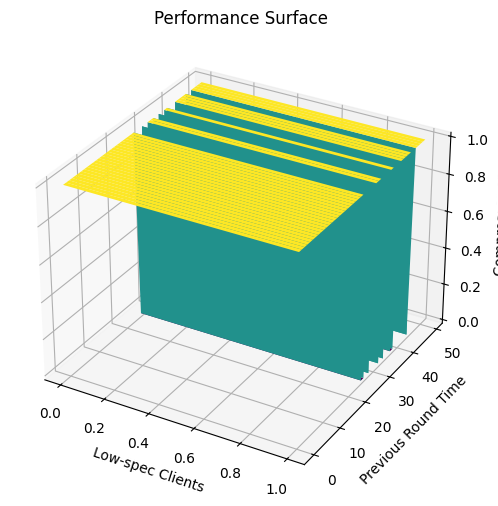

In [15]:
# ['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Compressor', 'Previous Total Time']

gpr_compressor = joblib.load('../predictors/bo_model_compressor-2-delay.pkl')

iid_data = np.arange(0, 2, 1)
round_time = np.arange(0, 50, 1)
X, Y = np.meshgrid(iid_data, round_time)


def objective(policy_on, high_spec, low_spec, iid, prev_time):  # binary: 0 or 1
    X = [[high_spec, low_spec, iid, policy_on[0], prev_time]]
    X_scaled = scaler_compressor.transform(X)
    y_pred = gpr_compressor.predict(X_scaled)[0]  # maximize → minimize negative
    return y_pred


Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        def wrapped_objective(policy_on):
            iid_data = X[i, j]
            prev_round_time = Y[i, j]

            return objective(policy_on, 2, 4, iid_data, prev_round_time)


        res = gp_minimize(wrapped_objective,  # objective fn
                          [(0, 1)],  # policy_on ∈ {0,1}
                          acq_func="EI",  # acquisition function
                          n_calls=10, random_state=42)

        Z[i, j] = res.x[0]

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Low-spec Clients')
ax.set_ylabel('Previous Round Time')
ax.set_zlabel('Compressor on')
plt.title("Performance Surface")
plt.show()

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

x = exp_data_selector[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Selector', 'FL Round', 'Previous F1/Time']]
y = exp_data_selector[['F1/Time']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

selector_tree_f1overtime = GradientBoostingRegressor(n_estimators=100, random_state=42)
selector_tree_f1overtime.fit(x_train, y_train)

print(selector_tree_f1overtime.score(x_train, y_train))
print(selector_tree_f1overtime.score(x_test, y_test))

with open("../predictors/f1overtime_xgboost_selector-2-{}.pkl".format(len(x_train)), "wb") as f:
    dump(selector_tree_f1overtime, f, protocol=5)

0.9812935182462035
0.9670011865656505


In [6]:
x = exp_data_hdh[['FL Round', 'HDH', 'Previous JSD', 'Previous Val F1']]
y = exp_data_hdh[['Filled F1']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

hdh_tree_f1overtime = DecisionTreeRegressor(max_depth=10)
hdh_tree_f1overtime.fit(x_train, y_train)

print(hdh_tree_f1overtime.score(x_train, y_train))
print(hdh_tree_f1overtime.score(x_test, y_test))

with open("../predictors/f1overtime_tree_hdh-2_{}.pkl".format(len(x_train)), "wb") as f:
    dump(hdh_tree_f1overtime, f, protocol=5)

0.9912045756057191
0.9858647282831895


In [ ]:
x = exp_data_compressor[
    ['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Compressor', 'Previous Communication Time']]
y = exp_data_compressor[['Communication Time']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

compressor_tree_f1overtime = DecisionTreeRegressor(max_depth=10)
compressor_tree_f1overtime.fit(x_train, y_train)

print(compressor_tree_f1overtime.score(x_train, y_train))
print(compressor_tree_f1overtime.score(x_test, y_test))

with open("../predictors/f1overtime_tree_compressor_{}.pkl".format(len(x_train)), "wb") as f:
    dump(compressor_tree_f1overtime, f, protocol=5)

In [ ]:
N_high = 5
N_low = 5

f1 = np.arange(0.002, 0.011, 0.00001)

plt.figure(figsize=(10, 6))

plt.plot(f1, [selector_tree_f1overtime.predict([[N_high, N_low, 0, True, v]])[0] for v in f1], color="black")
plt.plot(f1, [selector_tree_f1overtime.predict([[N_high, N_low, 0, False, v]])[0] for v in f1], '--', color="black")

plt.title('non-IID Data')

plt.show()

plt.figure(figsize=(10, 6))

plt.plot(f1, [selector_tree_f1overtime.predict([[N_high, N_low, 100, True, v]])[0] for v in f1], color="black")
plt.plot(f1, [selector_tree_f1overtime.predict([[N_high, N_low, 100, False, v]])[0] for v in f1], '--', color="black")

plt.title('IID Data')

plt.show()

In [ ]:
import matplotlib.patches as mpatches


def plot_decision_regions(selector_tree, N_high, N_low, iid_value, x_values):
    """
    Plots the decision tree's predictions for a pattern being active vs. inactive
    and colors the background based on which strategy is better.

    Args:
        selector_tree: The trained decision tree model with a .predict() method.
        N_high (int): Number of high-spec clients.
        N_low (int): Number of low-spec clients.
        iid_value (int): The IID data value (e.g., 100).
        x_values (np.ndarray): A range of values for the x-axis (e.g., previous F1 score).
    """
    # --- 1. Calculate the predictions for both lines ---
    # The 'solid' line represents the pattern being active (True)
    y_solid = [selector_tree.predict([[N_high, N_low, iid_value, True, 5, val]])[0] for val in x_values]

    # The 'dashed' line represents the pattern being inactive (False)
    y_dashed = [selector_tree.predict([[N_high, N_low, iid_value, False, 5, val]])[0] for val in x_values]

    # Convert to numpy arrays for easier comparison
    y_solid = np.array(y_solid)
    y_dashed = np.array(y_dashed)

    # --- 2. Create the plot ---
    fig, ax = plt.subplots(figsize=(10, 3))
    plt.style.use('seaborn-v0_8-white')

    # Plot the two prediction lines
    ax.plot(x_values, y_solid, color="black", label=r"$\hat{y}\vert\mathit{T}^{r}$", linewidth=1)
    ax.plot(x_values, y_dashed, '--', color="black", label=r"$\hat{y}\vert\neg\mathit{T}^{r}$", linewidth=1)

    # --- 3. Color the background regions ---
    # Determine where the solid line is better (>=) than the dashed line
    solid_is_better = y_solid > y_dashed

    # Define colors for the regions
    color_active = 'lightgreen'
    color_inactive = 'lightcoral'

    # Iterate through the x-values to find contiguous regions
    current_region_start = x_values[0]
    for i in range(1, len(x_values)):
        # A switch occurs if the "better" strategy changes
        if solid_is_better[i] != solid_is_better[i - 1]:
            # End the previous region
            region_end = x_values[i]
            region_color = color_active if solid_is_better[i - 1] else color_inactive
            ax.axvspan(current_region_start, region_end, color=region_color, alpha=0.3, zorder=0)

            # Start a new region
            current_region_start = region_end

    # Add the final region after the loop finishes
    final_region_color = color_active if solid_is_better[-1] else color_inactive
    ax.axvspan(current_region_start, x_values[-1], color=final_region_color, alpha=0.3, zorder=0)

    # --- 4. Formatting and Legend ---
    # ax.set_title("Decision Tree Policy Visualization", fontsize=16, weight='bold')
    ax.set_xlabel(r"Input ($\bar{x}$)", fontsize=12)
    ax.set_ylabel(r"Prediction ($\hat{y}$)", fontsize=12)

    # Create custom legend handles for the colored regions
    legend_patch_active = mpatches.Patch(color=color_active, alpha=1,
                                         label=r'$\hat{y}\vert\mathit{T}^{r}>\hat{y}\vert\neg\mathit{T}^{r}$: Activate Pattern')
    legend_patch_inactive = mpatches.Patch(color=color_inactive, alpha=1,
                                           label=r'$\hat{y}\vert\mathit{T}^{r}\leq\hat{y}\vert\neg\mathit{T}^{r}$: Deactivate Pattern')

    # Combine line legend with region legend
    handles, labels = ax.get_legend_handles_labels()
    handles.extend([legend_patch_active, legend_patch_inactive])
    ax.legend(handles=handles, facecolor='white', loc='best', fontsize=12)

    ax.set_xlim(x_values[0], x_values[-1])
    plt.savefig("plots/policies/decision_tree_policy_visualization.pdf", dpi=300, bbox_inches='tight')
    plt.show()


# Call the plotting function with the mock model and parameters
f1_values = np.arange(0.0033, 0.011, 0.00001)

plot_decision_regions(
    selector_tree=selector_tree_f1overtime,
    N_high=5,
    N_low=5,
    iid_value=100,
    x_values=f1_values
)

In [ ]:
# --- Define the independent variables for the meshgrid ---
# Use the same ranges as your previous plot, adjust if needed
rounds = np.linspace(1, 20, 20)
f1_over_time = np.arange(0.0001, 0.01, 0.0005)
X_mesh, Y_mesh = np.meshgrid(rounds, f1_over_time)  # Renamed to avoid confusion with X in objective


# --- Define your selector_tree prediction function ---
# This function will take the policy_on/off state and other features
# and return the prediction from selector_tree.
# I'm assuming the structure of your input X for selector_tree.
# Adjust the hardcoded values (5, 5, 100) and feature order to match
# what your selector_tree expects for the scaled input.
def get_selector_tree_prediction(selector_state, curr_round, prev_f1_overtime):
    # Construct the input array for selector_tree.
    # IMPORTANT: Ensure the feature order matches the training data of selector_tree.
    # This is a placeholder; you might need to adjust the fixed values (e.g., 5, 5, 100)
    # and the position of 'selector_state', 'curr_round', 'prev_f1_overtime'
    input_features = np.array([[5, 5, 100, selector_state, curr_round, prev_f1_overtime]])
    # input_scaled = scaler.transform(input_features)
    prediction = selector_tree_f1overtime.predict(input_features)[0]
    return prediction


# --- Prepare the Z array for the surface plot ---
Z = np.zeros_like(X_mesh, dtype=int)  # Z will contain 0s or 1s

for i in range(X_mesh.shape[0]):
    for j in range(X_mesh.shape[1]):
        curr_round = X_mesh[i, j]
        prev_f1_overtime = Y_mesh[i, j]

        # Get prediction when selector is ON (e.g., selector_state = 1)
        pred_selector_on = get_selector_tree_prediction(1, curr_round, prev_f1_overtime)

        # Get prediction when selector is OFF (e.g., selector_state = 0)
        pred_selector_off = get_selector_tree_prediction(0, curr_round, prev_f1_overtime)

        # Set Z to 1 if 'selector on' is better, else 0
        if pred_selector_on > pred_selector_off:
            Z[i, j] = 1  # Selector ON is preferred
        else:
            Z[i, j] = 0  # Selector OFF is preferred (or no significant difference)

# --- Colormap and Plotting ---
color_active = 'lightgreen'  # For Z=1 (selector_on > selector_off)
color_inactive = 'lightcoral'  # For Z=0 (selector_on <= selector_off)
colors = [color_inactive, color_active]
cmap = LinearSegmentedColormap.from_list("selector_cmap", colors, N=2)

fig = plt.figure(figsize=(15, 8))  # Adjusted figsize for better viewing
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1, 1, 0.25))  # Adjust Z-axis compression as needed

ax.plot_surface(X_mesh, Y_mesh, Z, cmap=cmap)

ax.set_xlabel('FL Round')
ax.set_xticks(rounds[::2])  # Show fewer ticks if `rounds` is too dense
ax.set_ylabel('Previous F1/Time')
ax.set_yticks(np.arange(0.0001, 0.01, 0.0009))
ax.set_zlabel('Selector Toggle State (1=ON, 0=OFF)')
ax.set_zticks([0, 1])  # Ensure only 0 and 1 are shown on Z-axis

plt.tight_layout()
plt.savefig("plots/policies/predictor_visualization.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [37]:
# Features and target
x = exp_data_selector[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Selector', 'FL Round', 'Previous F1/Time']]
y = exp_data_selector[['F1/Time']]

# Standardize input (important for GPR)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Define GPR with RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=42)

# Fit model
# WARNING!! Takes approx. 1 min to complete
gpr.fit(X_train, y_train)

joblib.dump(gpr, '../predictors/bo_model-selector-2.pkl')
joblib.dump(scaler, '../predictors/bo_scaler-selector-2.pkl')

# Predict on test set
y_pred, sigma = gpr.predict(X_test, return_std=True)

# Output example
for xi, pred, std in zip(X_test, y_pred, sigma):
    print(f"Input: {scaler.inverse_transform([xi])[0]} → Predicted accuracy: {pred:.3f} ± {std:.3f}")

Input: [2.00000000e+00 4.00000000e+00 0.00000000e+00 1.00000000e+00
 1.50000000e+01 3.50673195e-03] → Predicted accuracy: 0.003 ± 0.000
Input: [3.00000000e+00 3.00000000e+00 0.00000000e+00 0.00000000e+00
 1.50000000e+01 5.47834518e-03] → Predicted accuracy: 0.005 ± 0.001
Input: [3.00000000e+00 3.00000000e+00 0.00000000e+00 0.00000000e+00
 1.90000000e+01 2.67792909e-03] → Predicted accuracy: 0.004 ± 0.001
Input: [2.00000000e+00 4.00000000e+00 0.00000000e+00 0.00000000e+00
 3.00000000e+00 3.89227969e-03] → Predicted accuracy: 0.004 ± 0.001
Input: [2.00000000e+00 4.00000000e+00 0.00000000e+00 0.00000000e+00
 1.10000000e+01 3.00440917e-03] → Predicted accuracy: 0.004 ± 0.001
Input: [4.00000000e+00 2.00000000e+00 0.00000000e+00 0.00000000e+00
 3.00000000e+00 1.01275112e-03] → Predicted accuracy: 0.002 ± 0.000
Input: [3.00000000e+00 3.00000000e+00 0.00000000e+00 1.00000000e+00
 1.90000000e+01 2.98215906e-03] → Predicted accuracy: 0.003 ± 0.000
Input: [3.00000000e+00 3.00000000e+00 0.00000000

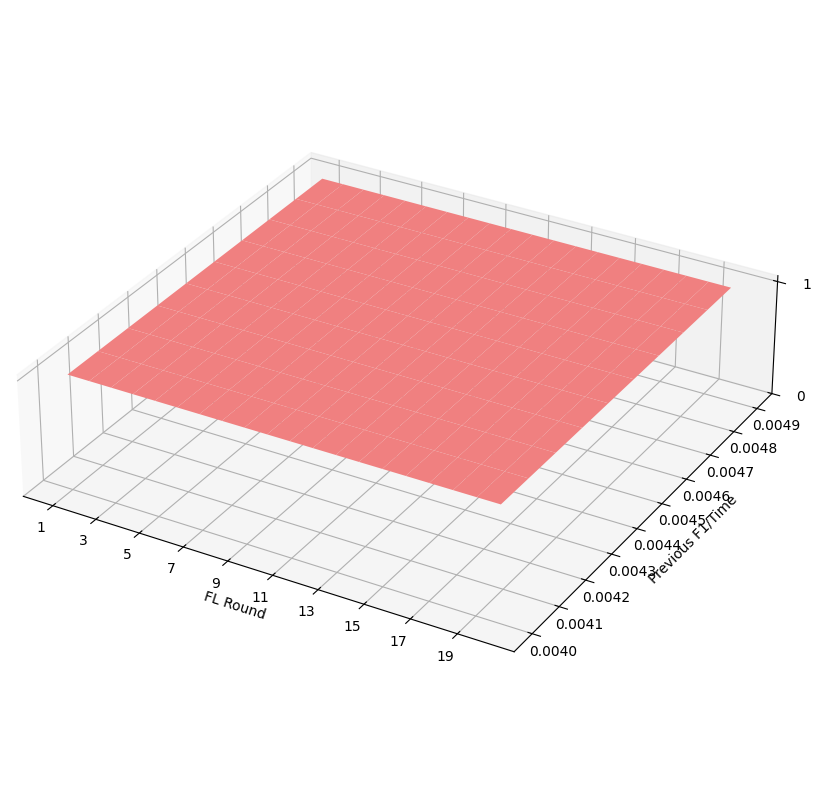

In [41]:
gpr = joblib.load('../predictors/bo_model-selector-2.pkl')

rounds = np.linspace(1, 20, 20)
f1_over_time = np.arange(0.004, 0.005, 0.0001)
X, Y = np.meshgrid(rounds, f1_over_time)


def objective(policy_on, curr_round, prev_f1_overtime):  # binary: 0 or 1
    X = [[3, 3, 100, policy_on[0], curr_round, prev_f1_overtime]]
    X_scaled = scaler.transform(X)
    y_pred = -gpr.predict(X_scaled)[0]  # maximize → minimize negative
    return y_pred


Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        def wrapped_objective(policy_on):
            curr_round = X[i, j]
            prev_f1_overtime = Y[i, j]

            return objective(policy_on, curr_round, prev_f1_overtime)


        res = gp_minimize(wrapped_objective,  # objective fn
                          [(0, 1)],  # policy_on ∈ {0,1}
                          acq_func="EI",  # acquisition function
                          n_calls=10, random_state=42)

        Z[i, j] = res.x[0]

color_active = 'lightgreen'
color_inactive = 'lightcoral'
colors = [color_inactive, color_active]
cmap = LinearSegmentedColormap.from_list("mycmap", colors, N=2)  # N=2 for 2 discrete values

# Plot the surface
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1, 1, 0.25))
ax.plot_surface(X, Y, Z, cmap=cmap)

ax.set_xlabel('FL Round')
ax.set_xticks(rounds[::2])
ax.set_ylabel('Previous F1/Time')
ax.set_yticks(f1_over_time)
ax.set_zlabel('Pattern Toggle State')
ax.set_zticks([0, 1])
plt.tight_layout()
plt.savefig("plots/policies/bo_visualization.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


In [7]:
# Features and target
x = exp_data_hdh[['FL Round', 'HDH', 'Previous JSD', 'Previous Val F1']]
y = exp_data_hdh[['Filled F1']]

# Standardize input (important for GPR)
scaler_hdh = StandardScaler()
X_scaled = scaler_hdh.fit_transform(x)

# Define GPR with RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
gpr_hdh = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=42)

# Fit model
# WARNING!! Takes approx. 1 min to complete
gpr_hdh.fit(X_train, y_train)

joblib.dump(gpr_hdh, '../predictors/bo_model_hdh-2.pkl')
joblib.dump(scaler_hdh, '../predictors/bo_scaler_hdh-2.pkl')

# Predict on test set
y_pred, sigma = gpr_hdh.predict(X_test, return_std=True)

# Output example
for xi, pred, std in zip(X_test, y_pred, sigma):
    print(f"Input: {scaler_hdh.inverse_transform([xi])[0]} → Predicted accuracy: {pred:.3f} ± {std:.3f}")

Input: [17.      1.      0.05    0.5019] → Predicted accuracy: 0.503 ± 0.001
Input: [19.      0.      0.05    0.5048] → Predicted accuracy: 0.495 ± 0.000
Input: [12.      0.      0.05    0.4981] → Predicted accuracy: 0.505 ± 0.000
Input: [10.      0.      0.05    0.5294] → Predicted accuracy: 0.528 ± 0.001
Input: [15.      0.      0.05    0.5132] → Predicted accuracy: 0.509 ± 0.000
Input: [9.     0.     0.05   0.5269] → Predicted accuracy: 0.525 ± 0.001
Input: [5.     0.     0.12   0.1895] → Predicted accuracy: 0.433 ± 3.458
Input: [14.      1.      0.06    0.4524] → Predicted accuracy: 0.485 ± 0.001
Input: [8.     0.     0.21   0.3251] → Predicted accuracy: 0.313 ± 0.328
Input: [9.     0.     0.08   0.3837] → Predicted accuracy: 0.300 ± 0.081
Input: [2.     0.     0.15   0.3415] → Predicted accuracy: 0.432 ± 3.445
Input: [19.      1.      0.11    0.5015] → Predicted accuracy: 0.490 ± 3.111
Input: [3.     0.     0.3    0.0683] → Predicted accuracy: 0.079 ± 1.525
Input: [16.      0.    

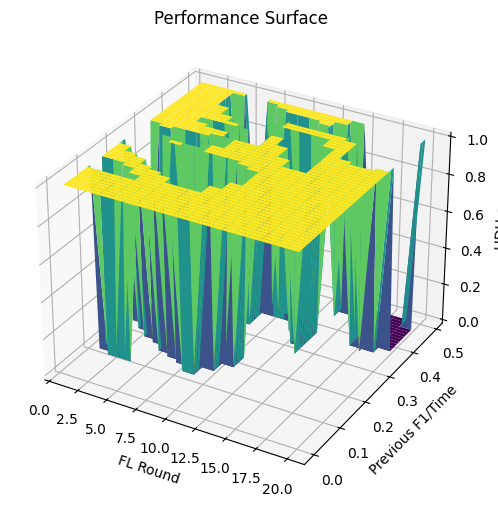

In [4]:
gpr_hdh = joblib.load('../predictors/bo_model_hdh-2.pkl')

rounds = np.linspace(1, 20, 20)
f1_over_time = np.arange(0, 0.5, 0.01)
X, Y = np.meshgrid(rounds, f1_over_time)

last_jsd = 0.1


def objective(policy_on, curr_round, last_jsd, prev_f1):  # binary: 0 or 1
    X = [[curr_round, policy_on[0], last_jsd, prev_f1]]
    X_scaled = scaler_hdh.transform(X)
    y_pred = -gpr_hdh.predict(X_scaled)[0]  # maximize → minimize negative
    return y_pred


Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        def wrapped_objective(policy_on):
            curr_round = X[i, j]
            prev_f1_overtime = Y[i, j]

            return objective(policy_on, curr_round, last_jsd, prev_f1_overtime)


        res = gp_minimize(wrapped_objective,  # objective fn
                          [(0, 1)],  # policy_on ∈ {0,1}
                          acq_func="EI",  # acquisition function
                          n_calls=10, random_state=42)

        Z[i, j] = res.x[0]

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('FL Round')
ax.set_ylabel('Previous F1/Time')
ax.set_zlabel('HDH on')
plt.title("Performance Surface")
plt.show()


In [ ]:
# Features and target
x = exp_data_compressor[
    ['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Compressor', 'Previous Communication Time']]
y = exp_data_compressor[['Communication Time']]

# Standardize input (important for GPR)
scaler_compressor = StandardScaler()
X_scaled = scaler_compressor.fit_transform(x)

# Define GPR with RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
gpr_compressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=42)

# Fit model
# WARNING!! Takes approx. 1 min to complete
gpr_compressor.fit(X_train, y_train)

joblib.dump(gpr_compressor, '../predictors/bo_model_compressor.pkl')
joblib.dump(scaler_compressor, '../predictors/bo_scaler_compressor.pkl')

# Predict on test set
y_pred, sigma = gpr_compressor.predict(X_test, return_std=True)

# Output example
for xi, pred, std in zip(X_test, y_pred, sigma):
    print(f"Input: {scaler_compressor.inverse_transform([xi])[0]} → Predicted accuracy: {pred:.3f} ± {std:.3f}")

In [ ]:
# ['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Compressor', 'Previous Total Time']

gpr_compressor = joblib.load('../predictors/bo_model_compressor.pkl')

iid_data = np.arange(0, 2, 1)
round_time = np.arange(0, 200, 1)
X, Y = np.meshgrid(iid_data, round_time)


def objective(policy_on, high_spec, low_spec, iid, prev_time):  # binary: 0 or 1
    X = [[high_spec, low_spec, iid, policy_on[0], prev_time]]
    X_scaled = scaler_compressor.transform(X)
    y_pred = gpr_compressor.predict(X_scaled)[0]  # maximize → minimize negative
    return y_pred


Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        def wrapped_objective(policy_on):
            iid_data = X[i, j]
            prev_round_time = Y[i, j]

            return objective(policy_on, 5, 5, iid_data, prev_round_time)


        res = gp_minimize(wrapped_objective,  # objective fn
                          [(0, 1)],  # policy_on ∈ {0,1}
                          acq_func="EI",  # acquisition function
                          n_calls=10, random_state=42)

        Z[i, j] = res.x[0]

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Low-spec Clients')
ax.set_ylabel('Previous Round Time')
ax.set_zlabel('Compressor on')
plt.title("Performance Surface")
plt.show()

In [ ]:
folders = ['vm/new/3high-3low/0iid', 'vm/new/3high-3low/100iid',
           'vm/new/5high-5low/0iid', 'vm/new/5high-5low/100iid',
           'vm/new/10high-10low/0iid', 'vm/new/10high-10low/100iid',
           'vm/new/4high-2low/0iid', 'vm/new/4high-2low/100iid',
           'vm/new/8high-4low/0iid', 'vm/new/8high-4low/100iid',
           'vm/new/2high-4low/0iid', 'vm/new/2high-4low/100iid',
           'vm/new/4high-8low/0iid', 'vm/new/4high-8low/100iid',
           'vm/new/2high-8low/0iid', 'vm/new/2high-8low/100iid']

selected_confs = ['always-selector-text', 'random-selector-text', 'no-selector-text']
exp_data_selector: pd.DataFrame = pd.DataFrame()

for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        if exp_path.split('/')[-1].split('_')[0] not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['N. Clients'] = df.apply(lambda x: x['Client ID'].split('Client ')[1].split('\n')[0], axis=1)
            last_client = [int(x) for x in df['N. Clients'].unique()]
            df['High-Spec Clients'] = int(folder.split('/')[2].split('high-')[0])
            df['Low-Spec Clients'] = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df = df[df['Val F1'] >= 0]
            df['Previous Val F1'] = df.shift(1)['Val F1']
            df['Previous F1/Time'] = df.shift(1)['F1/Time']
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])
            df = df[df['FL Round'] > 1]

            # determines whether selector was activated for the round
            df['Selector'] = df['N. Clients'].apply(lambda n: int(n) != max(last_client))

            df = df[['Exp Name', 'N. Clients', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'Selector', 'Total Time of FL Round', 'Previous F1/Time', 'Previous Val F1', 'F1/Time', 'Val F1']]
            exp_data_selector = pd.concat([exp_data_selector, df])

print(exp_data_selector)

In [ ]:
# --- Define the independent variables for the meshgrid ---
# Use the same ranges as your previous plot, adjust if needed
rounds = np.linspace(1, 20, 20)
f1_over_time = np.arange(0.01, 0.08, 0.001)
X_mesh, Y_mesh = np.meshgrid(rounds, f1_over_time)  # Renamed to avoid confusion with X in objective


# --- Define your selector_tree prediction function ---
# This function will take the policy_on/off state and other features
# and return the prediction from selector_tree.
# I'm assuming the structure of your input X for selector_tree.
# Adjust the hardcoded values (5, 5, 100) and feature order to match
# what your selector_tree expects for the scaled input.
def get_selector_tree_prediction(selector_state, curr_round, prev_f1_overtime):
    # Construct the input array for selector_tree.
    # IMPORTANT: Ensure the feature order matches the training data of selector_tree.
    # This is a placeholder; you might need to adjust the fixed values (e.g., 5, 5, 100)
    # and the position of 'selector_state', 'curr_round', 'prev_f1_overtime'
    input_features = np.array([[5, 5, 0, selector_state, curr_round, prev_f1_overtime]])
    # input_scaled = scaler.transform(input_features)
    prediction = regressor.predict(input_features)[0]
    return prediction


# --- Prepare the Z array for the surface plot ---
Z = np.zeros_like(X_mesh, dtype=int)  # Z will contain 0s or 1s

for i in range(X_mesh.shape[0]):
    for j in range(X_mesh.shape[1]):
        curr_round = X_mesh[i, j]
        prev_f1_overtime = Y_mesh[i, j]

        # Get prediction when selector is ON (e.g., selector_state = 1)
        pred_selector_on = get_selector_tree_prediction(1, curr_round, prev_f1_overtime)

        # Get prediction when selector is OFF (e.g., selector_state = 0)
        pred_selector_off = get_selector_tree_prediction(0, curr_round, prev_f1_overtime)

        # Set Z to 1 if 'selector on' is better, else 0
        if pred_selector_on > pred_selector_off:
            Z[i, j] = 1  # Selector ON is preferred
        else:
            Z[i, j] = 0  # Selector OFF is preferred (or no significant difference)

# --- Colormap and Plotting ---
color_active = 'lightgreen'  # For Z=1 (selector_on > selector_off)
color_inactive = 'lightcoral'  # For Z=0 (selector_on <= selector_off)
colors = [color_inactive, color_active]
cmap = LinearSegmentedColormap.from_list("selector_cmap", colors, N=2)

fig = plt.figure(figsize=(15, 8))  # Adjusted figsize for better viewing
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1, 1, 0.25))  # Adjust Z-axis compression as needed

ax.plot_surface(X_mesh, Y_mesh, Z, cmap=cmap)

ax.set_xlabel('FL Round')
ax.set_xticks(rounds[::2])  # Show fewer ticks if `rounds` is too dense
ax.set_ylabel('Previous F1/Time')
ax.set_yticks(np.arange(0.05, 0.1, 0.001))
ax.set_zlabel('Selector Toggle State (1=ON, 0=OFF)')
ax.set_zticks([0, 1])  # Ensure only 0 and 1 are shown on Z-axis

plt.tight_layout()
plt.savefig("plots/policies/predictor_visualization_text.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
# Features and target
x = exp_data_selector[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Selector', 'FL Round', 'Previous F1/Time']]
y = exp_data_selector[['F1/Time']]

# Standardize input (important for GPR)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Define GPR with RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=42)

# Fit model
# WARNING!! Takes approx. 1 min to complete
gpr.fit(X_train, y_train)

joblib.dump(gpr, '../predictors/bo_model_selector_text_new.pkl')
joblib.dump(scaler, '../predictors/bo_scaler_selector_text_new.pkl')

# Predict on test set
y_pred, sigma = gpr.predict(X_test, return_std=True)

# Output example
for xi, pred, std in zip(X_test, y_pred, sigma):
    print(f"Input: {scaler.inverse_transform([xi])[0]} → Predicted accuracy: {pred:.3f} ± {std:.3f}")

In [ ]:
gpr = joblib.load('../predictors/bo_model_selector_text_new.pkl')

rounds = np.linspace(1, 20, 20)
f1_over_time = np.arange(0.02, 0.05, 0.005)
X, Y = np.meshgrid(rounds, f1_over_time)


def objective(policy_on, curr_round, prev_f1_overtime):  # binary: 0 or 1
    X = [[2, 4, 100, policy_on[0], curr_round, prev_f1_overtime]]
    X_scaled = scaler.transform(X)
    y_pred = -gpr.predict(X_scaled)[0]  # maximize → minimize negative
    return y_pred


Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        def wrapped_objective(policy_on):
            curr_round = X[i, j]
            prev_f1_overtime = Y[i, j]

            return objective(policy_on, curr_round, prev_f1_overtime)


        res = gp_minimize(wrapped_objective,  # objective fn
                          [(0, 1)],  # policy_on ∈ {0,1}
                          acq_func="EI",  # acquisition function
                          n_calls=10, random_state=42)

        Z[i, j] = res.x[0]

color_active = 'lightgreen'
color_inactive = 'lightcoral'
colors = [color_inactive, color_active]
cmap = LinearSegmentedColormap.from_list("mycmap", colors, N=2)  # N=2 for 2 discrete values

# Plot the surface
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1, 1, 0.25))
ax.plot_surface(X, Y, Z, cmap=cmap)

ax.set_xlabel('FL Round')
ax.set_xticks(rounds[::2])
ax.set_ylabel('Previous F1/Time')
ax.set_yticks(f1_over_time)
ax.set_zlabel('Pattern Toggle State')
ax.set_zticks([0, 1])
plt.tight_layout()
plt.savefig("plots/policies/bo_visualization_selector_text.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


In [ ]:
folders = ['vm/new/3high-3low/0iid', 'vm/new/4high-8low/0iid',
           'vm/new/5high-5low/0iid', 'vm/new/2high-8low/0iid',
           'vm/new/4high-2low/0iid', 'vm/new/8high-4low/0iid',
           'vm/new/2high-4low/0iid']
selected_confs = ['no-hdh-text', 'random-hdh-text', 'always-hdh-text']
exp_data_hdh_text: pd.DataFrame = pd.DataFrame()


def shift_row(row, col_to_shift, shift_col, dataframe):
    return dataframe[col_to_shift].shift(row[shift_col])[row.name]


for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        exp_name = exp_path.split('/')[-1].split('_')[0]
        if exp_name not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['Client ID'] = df.apply(lambda x: int(x['Client ID'].split('Client ')[1].split('\n')[0]), axis=1)
            last_client = max([int(x) for x in df['Client ID'].unique()])
            high_spec_clients = int(folder.split('/')[2].split('high-')[0])
            low_spec_clients = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df['High-Spec Clients'] = high_spec_clients
            df['Low-Spec Clients'] = low_spec_clients
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])

            df['Previous JSD'] = df.shift(high_spec_clients + low_spec_clients)['JSD']

            df['HDH'] = df.apply(lambda x: x['HDH Time'] > 0.0, axis=1)
            df['shift_by'] = df.apply(lambda x: x['Client ID'] - last_client, axis=1)
            df['Filled F1/Time'] = df.apply(lambda row: shift_row(row, "F1/Time", "shift_by", df), axis=1)
            df['Filled F1'] = df.apply(lambda row: shift_row(row, "Val F1", "shift_by", df), axis=1)

            df['Previous Val F1'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1']
            df['Previous F1/Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1/Time']

            df['Final F1/Time'] = df["F1/Time"].iloc[-1]
            df['Final F1'] = df["Val F1"].iloc[-1]

            df = df[df['FL Round'] > 1]

            df = df[['Exp Name', 'Client ID', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'HDH', 'Total Time of FL Round', 'JSD', 'Previous JSD', 'F1/Time', 'Val F1',
                     'Previous Val F1', 'Previous F1/Time',
                     'Filled F1', 'Filled F1/Time', 'Final F1/Time', 'Final F1']]
            exp_data_hdh_text = pd.concat([exp_data_hdh_text, df])

print(exp_data_hdh_text)

In [ ]:
# Features and target
x = exp_data_hdh_text[['FL Round', 'HDH', 'Previous JSD', 'Previous Val F1']]
y = exp_data_hdh_text[['Filled F1']]

# Standardize input (important for GPR)
scaler_hdh = StandardScaler()
X_scaled = scaler_hdh.fit_transform(x)

# Define GPR with RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
gpr_hdh = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=42)

# Fit model
# WARNING!! Takes approx. 1 min to complete
gpr_hdh.fit(X_train, y_train)

joblib.dump(gpr_hdh, '../predictors/bo_model_hdh_text.pkl')
joblib.dump(scaler_hdh, '../predictors/bo_scaler_hdh_text.pkl')

# Predict on test set
y_pred, sigma = gpr_hdh.predict(X_test, return_std=True)

# Output example
for xi, pred, std in zip(X_test, y_pred, sigma):
    print(f"Input: {scaler_hdh.inverse_transform([xi])[0]} → Predicted accuracy: {pred:.3f} ± {std:.3f}")

In [ ]:
gpr_hdh = joblib.load('../predictors/bo_model_hdh_text.pkl')

rounds = np.linspace(1, 20, 20)
f1_over_time = np.arange(0, 1.0, 0.1)
X, Y = np.meshgrid(rounds, f1_over_time)

last_jsd = 0.1


def objective(policy_on, curr_round, last_jsd, prev_f1):  # binary: 0 or 1
    X = [[curr_round, policy_on[0], last_jsd, prev_f1]]
    X_scaled = scaler_hdh.transform(X)
    y_pred = -gpr_hdh.predict(X_scaled)[0]  # maximize → minimize negative
    return y_pred


Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        def wrapped_objective(policy_on):
            curr_round = X[i, j]
            prev_f1_overtime = Y[i, j]

            return objective(policy_on, curr_round, last_jsd, prev_f1_overtime)


        res = gp_minimize(wrapped_objective,  # objective fn
                          [(0, 1)],  # policy_on ∈ {0,1}
                          acq_func="EI",  # acquisition function
                          n_calls=10, random_state=42)

        Z[i, j] = res.x[0]

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('FL Round')
ax.set_ylabel('Previous F1/Time')
ax.set_zlabel('HDH on')
plt.title("Performance Surface")
plt.show()


In [ ]:
folders = ['vm/same/2high-4low/0iid', 'vm/same/2high-8low/100iid',
           'vm/same/3high-3low/0iid', 'vm/same/4high-2low/100iid',
           'vm/same/4high-8low/0iid', 'vm/same/5high-5low/100iid',
           'vm/same/8high-4low/0iid', 'vm/same/10high-10low/100iid', ]
selected_confs = ['always-compressor-2', 'no-compressor-2']
exp_data_compressor_text: pd.DataFrame = pd.DataFrame()


def shift_row(row, col_to_shift, shift_col, dataframe):
    return dataframe[col_to_shift].shift(row[shift_col])[row.name]


for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        exp_name = exp_path.split('/')[-1].split('_')[0]
        if exp_name not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['Client ID'] = df.apply(lambda x: int(x['Client ID'].split('Client ')[1].split('\n')[0]), axis=1)
            last_client = max([int(x) for x in df['Client ID'].unique()])
            high_spec_clients = int(folder.split('/')[2].split('high-')[0])
            low_spec_clients = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df['High-Spec Clients'] = high_spec_clients
            df['Low-Spec Clients'] = low_spec_clients
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])

            df['Compressor'] = exp_name.split('-')[0] == 'always'

            df['shift_by'] = df.apply(lambda x: x['Client ID'] - last_client, axis=1)
            df['Filled F1/Time'] = df.apply(lambda row: shift_row(row, "F1/Time", "shift_by", df), axis=1)
            df['Filled F1'] = df.apply(lambda row: shift_row(row, "Val F1", "shift_by", df), axis=1)
            df['Filled Total Time'] = df.apply(lambda row: shift_row(row, "Total Time of FL Round", "shift_by", df),
                                               axis=1)

            df['Previous Communication Time'] = df.shift(high_spec_clients + low_spec_clients)['Communication Time']
            df['Previous Val F1'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1']
            df['Previous Total Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled Total Time']
            df['Previous F1/Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1/Time']

            df['Final F1/Time'] = df["F1/Time"].iloc[-1]
            df['Final F1'] = df["Val F1"].iloc[-1]

            df = df[df['FL Round'] > 1]

            df = df[['Exp Name', 'Client ID', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'Total Time of FL Round', 'F1/Time', 'Previous Total Time', 'Compressor',
                     'Previous Communication Time', 'Filled Total Time',
                     'Communication Time', 'Filled F1/Time', 'Final F1/Time']]
            exp_data_compressor_text = pd.concat([exp_data_compressor_text, df])

print(exp_data_compressor_text.sample(n=1000, random_state=42)['Total Time of FL Round'].sum())

In [ ]:
folders = ['vm/same/2high-4low/0iid', 'vm/same/2high-8low/100iid',
           'vm/same/3high-3low/0iid', 'vm/same/4high-2low/100iid',
           'vm/same/4high-8low/0iid', 'vm/same/5high-5low/100iid',
           'vm/same/8high-4low/0iid', 'vm/same/10high-10low/100iid', ]
selected_confs = ['always-compressor-text', 'no-compressor-text', 'always-compressor-text-delay', 'no-compressor-text-delay']
exp_data_compressor_text: pd.DataFrame = pd.DataFrame()


def shift_row(row, col_to_shift, shift_col, dataframe):
    return dataframe[col_to_shift].shift(row[shift_col])[row.name]


for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        exp_name = exp_path.split('/')[-1].split('_')[0]
        if exp_name not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['Client ID'] = df.apply(lambda x: int(x['Client ID'].split('Client ')[1].split('\n')[0]), axis=1)
            last_client = max([int(x) for x in df['Client ID'].unique()])
            high_spec_clients = int(folder.split('/')[2].split('high-')[0])
            low_spec_clients = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df['High-Spec Clients'] = high_spec_clients
            df['Low-Spec Clients'] = low_spec_clients
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])

            df['Compressor'] = exp_name.split('-')[0] == 'always'

            df['shift_by'] = df.apply(lambda x: x['Client ID'] - last_client, axis=1)
            df['Filled F1/Time'] = df.apply(lambda row: shift_row(row, "F1/Time", "shift_by", df), axis=1)
            df['Filled F1'] = df.apply(lambda row: shift_row(row, "Val F1", "shift_by", df), axis=1)
            df['Filled Total Time'] = df.apply(lambda row: shift_row(row, "Total Time of FL Round", "shift_by", df),
                                               axis=1)

            df['Previous Communication Time'] = df.shift(high_spec_clients + low_spec_clients)['Communication Time']
            df['Previous Val F1'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1']
            df['Previous Total Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled Total Time']
            df['Previous F1/Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1/Time']

            df['Final F1/Time'] = df["F1/Time"].iloc[-1]
            df['Final F1'] = df["Val F1"].iloc[-1]

            df = df[df['FL Round'] > 1]

            df = df[['Exp Name', 'Client ID', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'Total Time of FL Round', 'F1/Time', 'Previous Total Time', 'Compressor',
                     'Previous Communication Time', 'Filled Total Time',
                     'Communication Time', 'Filled F1/Time', 'Final F1/Time']]
            exp_data_compressor_text = pd.concat([exp_data_compressor_text, df])

print(exp_data_compressor_text.sample(n=1000, random_state=42)['Total Time of FL Round'].sum())

In [ ]:
# Features and target
x = exp_data_compressor_text[
    ['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Compressor', 'Previous Communication Time']]
y = exp_data_compressor_text[['Communication Time']]

# Standardize input (important for GPR)
scaler_compressor = StandardScaler()
X_scaled = scaler_compressor.fit_transform(x)

# Define GPR with RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
gpr_compressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=42)

# Fit model
# WARNING!! Takes approx. 1 min to complete
gpr_compressor.fit(X_train, y_train)

joblib.dump(gpr_compressor, '../predictors/bo_model_compressor_text.pkl')
joblib.dump(scaler_compressor, '../predictors/bo_scaler_compressor_text.pkl')

# Predict on test set
y_pred, sigma = gpr_compressor.predict(X_test, return_std=True)

# Output example
for xi, pred, std in zip(X_test, y_pred, sigma):
    print(f"Input: {scaler_compressor.inverse_transform([xi])[0]} → Predicted accuracy: {pred:.3f} ± {std:.3f}")

In [ ]:
# ['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Compressor', 'Previous Total Time']

gpr_compressor = joblib.load('../predictors/bo_model_compressor_text.pkl')

iid_data = np.arange(0, 2, 1)
round_time = np.arange(0, 10, 0.5)
X, Y = np.meshgrid(iid_data, round_time)


def objective(policy_on, high_spec, low_spec, iid, prev_time):  # binary: 0 or 1
    X = [[high_spec, low_spec, iid, policy_on[0], prev_time]]
    X_scaled = scaler_compressor.transform(X)
    y_pred = gpr_compressor.predict(X_scaled)[0]  # maximize → minimize negative
    return y_pred


Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        def wrapped_objective(policy_on):
            iid_data = X[i, j]
            prev_round_time = Y[i, j]

            return objective(policy_on, 5, 5, iid_data, prev_round_time)


        res = gp_minimize(wrapped_objective,  # objective fn
                          [(0, 1)],  # policy_on ∈ {0,1}
                          acq_func="EI",  # acquisition function
                          n_calls=10, random_state=42)

        Z[i, j] = res.x[0]

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Low-spec Clients')
ax.set_ylabel('Previous Round Time')
ax.set_zlabel('Compressor on')
plt.title("Performance Surface")
plt.show()